<h1>Часть 1. Изучение данных</h1>

Считаем данные в дейтафрейм и посмотрим на распределения величин

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
raw = pd.read_excel("data.xlsx")
raw.head()

,A,B,C,D,E,F,G,H,I,grade
0,55,16,84,0.98,3,6,91,8,С,50.508333
1,81,5,71,0.81,2,1,98,43,С,86.670000
2,99,28,48,0.81,3,0,41,12,С,90.915000
3,61,13,23,0.70,2,1,84,87,С,53.883333
4,95,17,81,0.10,5,3,83,21,С,80.591667


In [2]:
columns = raw.columns
raw.describe()

,A,B,C,D,E,F,G,H,grade
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,51.346173,16.750375,50.201101,0.505593,4.445723,3.983492,69.677839,50.566283,45.518694
std,29.072314,7.853655,28.778443,0.291200,2.286954,2.630427,17.445102,28.625441,26.177039
min,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,40.000000,1.000000,0.778333
25%,26.000000,10.000000,25.000000,0.260000,2.000000,2.000000,54.000000,26.000000,23.248333
50%,52.000000,17.000000,49.000000,0.510000,4.000000,4.000000,69.000000,51.000000,45.580000
75%,77.000000,24.000000,75.000000,0.760000,6.000000,6.000000,85.000000,76.000000,67.833333
max,100.000000,30.000000,100.000000,1.000000,8.000000,8.000000,100.000000,100.000000,100.000000


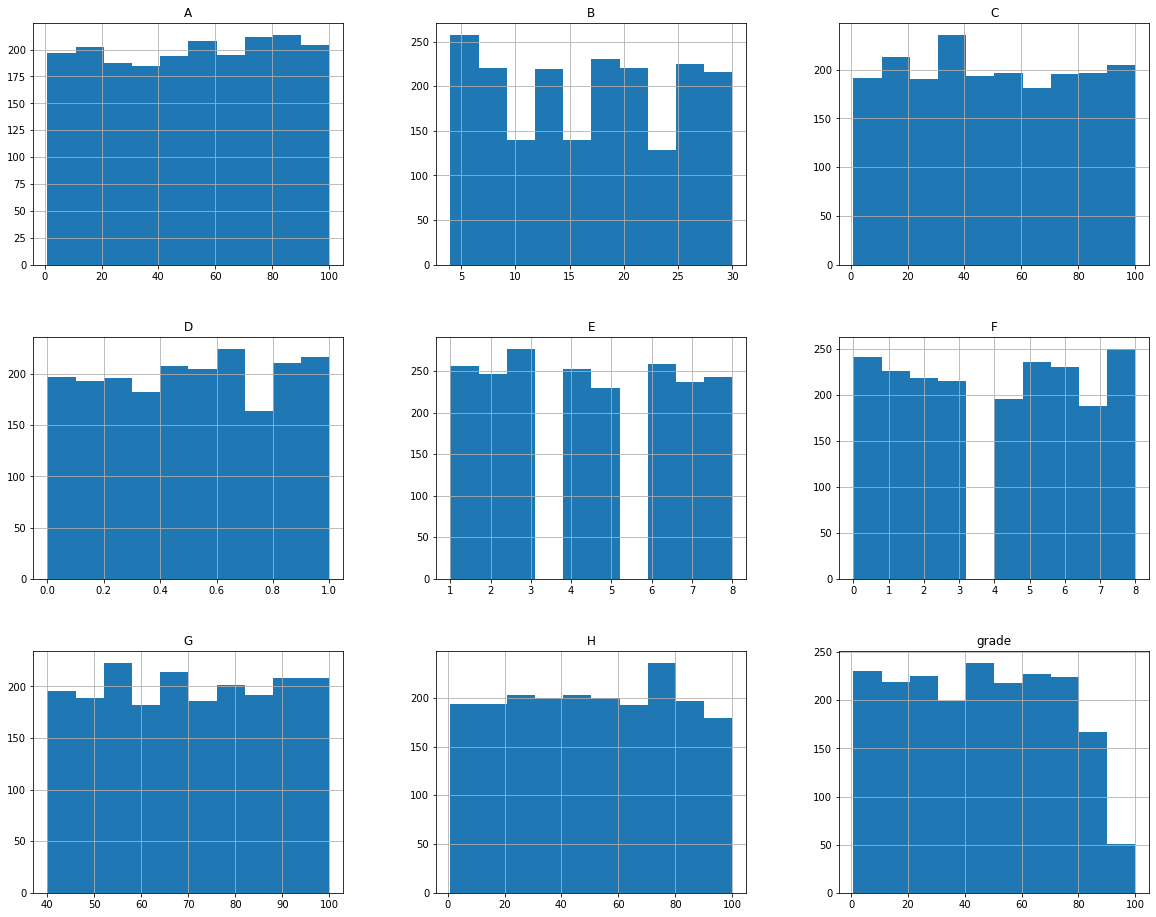

In [4]:
raw.hist(figsize=(20,16));

Похоже, что все столбцы обладают равномерным распределением. Провалы в распределениях E и F объясняются особенностью построения гистограмм для целых чисел. Посмотрим на матрицу корреляций, чтобы прикинуть, какие из столюцов коррелируют с целевой переменной:

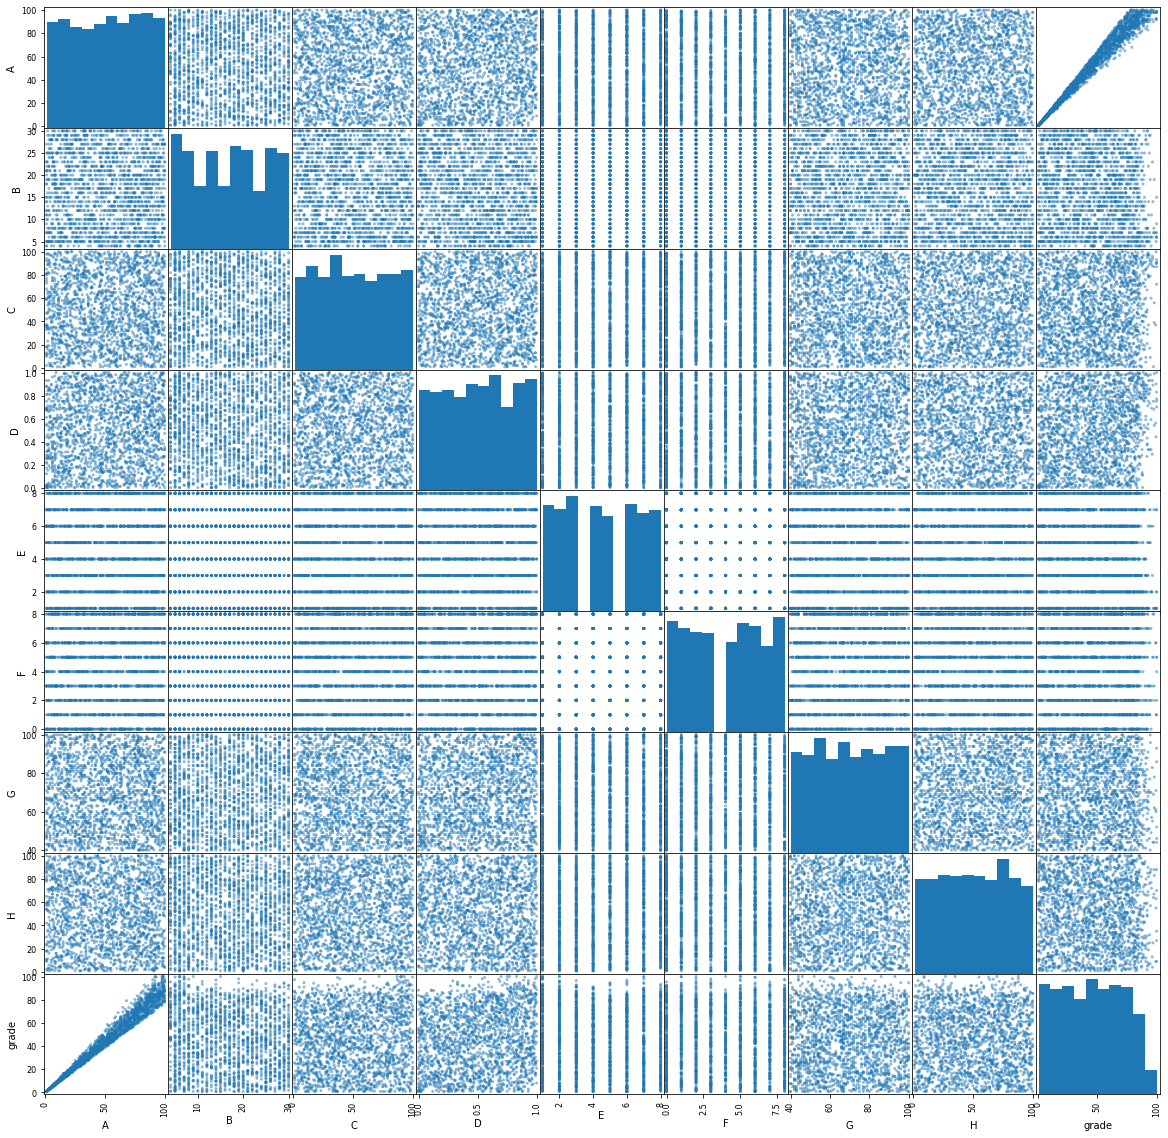

In [5]:
pd.plotting.scatter_matrix(raw, figsize=(20,20));

Видим, что с целевой переменной коррелирует только столбец А, остальные не коррелируют ни с ней, ни друг с другом. Похоже, это просто выборки белого шума (случайное равномерное распределение). Взглянем на корреляции в числнном выражении:

<AxesSubplot:>

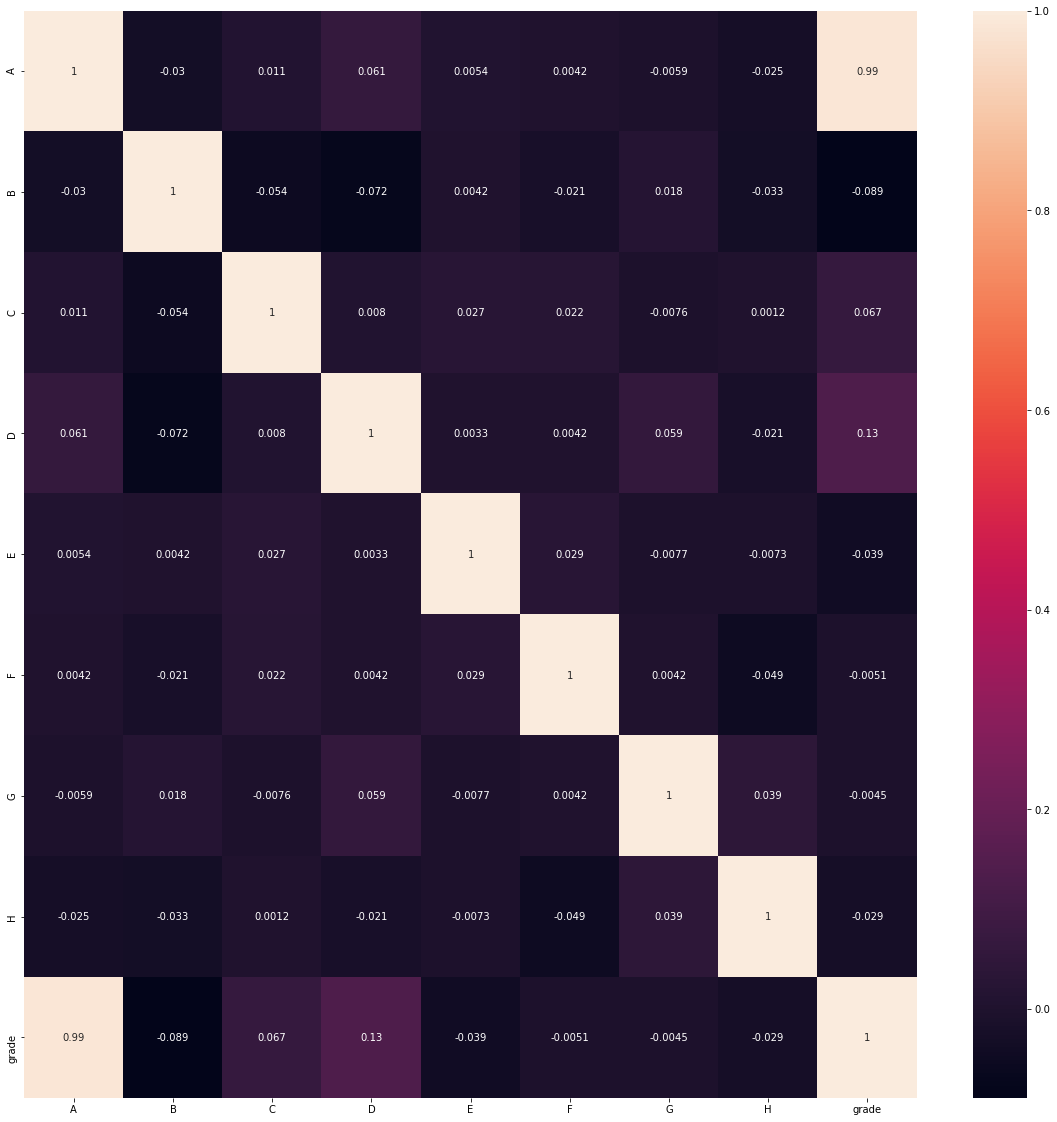

In [64]:
import seaborn as sns
corr = raw.corr()

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True, ax=ax)

Почти для всех столбцов корреляции Пирсона менее 0.1, C и D еще как-то коррелируют с целевой переменной. Построим теперь scatter plot в осях (A,grade) с разделением по категориям I

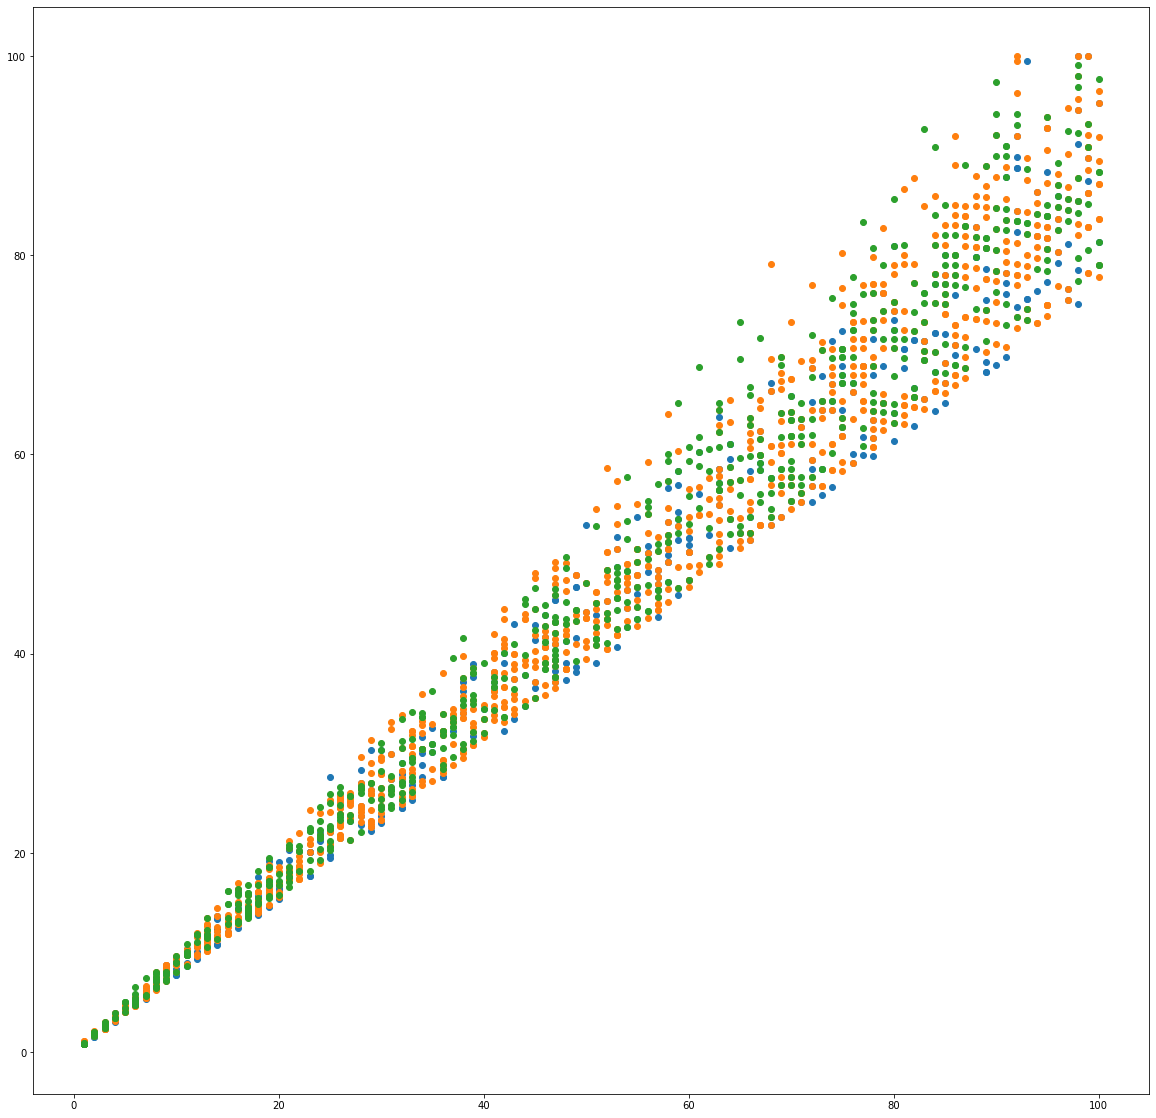

{'Т', 'С', 'Ф'}


In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
for i in set(raw["I"].values):
    plt.scatter(raw[raw["I"]==i]["A"],raw[raw["I"]==i]["grade"])
plt.show()
print(set(raw["I"].values))

Выглядит, как будто grade=a*0.8 + rand(a*0.2), хотя слабые зависимости от I C D тоже присутствуют

<h1>Часть 2. Подбор моделей</h1>

Подготовим данные и разобьем на обучающую и тестовую выборки. Переменную I закодируем через one-hot encoding, превратив в вектор длины 3(кол-во значений). Теоретически, другие финитные (целочисленные) переменные тоже можно так закодировать, чтобы избавиться от порядковых отнощений, но мне ничего неизвестно об из природе, так что я не буду этого делать

In [3]:
numerical_columns = list(columns)
numerical_columns.remove("I")
numerical_columns.remove("grade")

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)

data = raw[numerical_columns].values

#категориальную переменную I кодируем через one-hot
categorical = encoder.fit_transform(raw["I"].values.reshape(-1, 1)) 

data = np.hstack((data,categorical))

#шкалирование, чтобы избежать слишком больших весов в моделях
data = scaler.fit_transform(data)

target=raw["grade"].values

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

#проверим размеры полученных выборок
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1399, 11) (600, 11) (1399,) (600,)


В качестве моделей рассмотрим 4 различных линейных модели, 2 ансамбля и полносвязную нейросеть. Исходя из природы данных, можно предположить, что самая простая линейная регрессия на столбцы A,C,D,I справится лучше всего. Можно использовать sklearn.feature_selection.RFE и настроить n_features_to_select как гиперпараметр чтобы откинуть лишние столбцы, но в условии задачи сказано использовать все данные. 
<br>
Три следующие модели (Lasso, Ridge и ElasticNet) применяют регуляризацию, то есть зануление весов при малозначимых признаках. По идее, ElasticNet является комбинацией двух предыдущих, но, на моей практике, она иногда работает хуже, поэтому две предыдущие тоже обучим.
<br>
Далее следуют две модели - ансамбля: случайный лес и XGBoost. Обе основаны на решающих деревьях и способны находить нелинейные зависимости, однако, им требуется большой объем памяти, ресурсов и прербор по обширной сетке гиперпараметров для настройки. Здесь я задам довольно грубую сетку гиперпараметров, чтобы не замедлять обучение слишком сильно.
<br>
Далее полносвязный перцептрон с перебором по сетке коэффициентов регуляризации и кол-ва и ширины скрытых слоев. Опять же, здесь я использую довольно грубую сетку. 

In [25]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Коэффициенты регуляризации
alphas = np.linspace(0.1,10.,10)

#Соотношение между типами регуляризации для ElasticNet
l1_ratio = np.linspace(0.,1.,10)

#Гиперпараметры для леса и ансамбля
forest_grid = {"n_estimators": [int(x) for x in np.linspace(5,500,5)],
               "max_depth":[int(x) for x in np.linspace(1,100,5)],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [1, 2, 4]}

#Гиперпараметры нейросети
neural_grid = {"hidden_layer_sizes": [(),(20),(100),(50,50)],
               "solver":["lbfgs"],
               "alpha":alphas}

models_pool = {"SimpleReg":LinearRegression(),
               "Lasso":LassoCV(alphas=alphas),
               "Ridge":RidgeCV(alphas=alphas),
               "Elastic":ElasticNetCV(l1_ratio=l1_ratio,alphas=alphas),
               "Forest":GridSearchCV(RandomForestRegressor(),forest_grid),
               "XGBoost":GridSearchCV(GradientBoostingRegressor(),forest_grid),
               "NeuralNet":GridSearchCV(MLPRegressor(),neural_grid)}
scores=dict()

from tqdm import tqdm
for name in tqdm(models_pool.keys()):
    models_pool[name].fit(X_train,y_train);
    scores[name] = models_pool[name].score(X_test,y_test)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346551.3310735955, tolerance: 76.21548770854533
  tol, rng, random, positive)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number

 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [39:47<09:38, 578.54s/it]C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_mu

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\2\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

['Elastic', 'Forest', 'Lasso', 'NeuralNet', 'Ridge', 'SimpleReg', 'XGBoost']

In [29]:
#Взглянем на результаты всех моделей на тестовой выборке (коэффициент детерминации)
scores = dict(sorted(scores.items(), key=lambda item: item[1],reverse=True))
scores

{'NeuralNet': 0.9975452825518434,
 'XGBoost': 0.9951986753292825,
 'Forest': 0.9933349171726171,
 'SimpleReg': 0.9863855188154921,
 'Ridge': 0.9863729491662451,
 'Lasso': 0.9863516693636522,
 'Elastic': 0.9863516693636522}

Как и предполагалось, простая регрессия получила результат чуть лучше, чем усложненные. Однако, нелинейные модели справились еще лучше, хотя разница незначительна. Далее будем работать с тремя лучшими моделями, но, если бы это был реальный кейс и нужна была бы модель в продакшн, я бы выбрал самую простую регрессию

Проверим, как модели сохраняются в joblib и загружаются

In [52]:
import joblib
for name in list(scores.keys())[:3]:
    joblib.dump(models_pool[name].best_estimator_, "{}.pkl".format(name))

#Обученные энкодер и скейлер тоже обязательно сохранить, т.к. они необходимы для работы моделей
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

In [33]:
loaded_model = joblib.load(open("NeuralNet.pkl", "rb"))
loaded_model.score(X_test, y_test)

0.9975452825518434

Все в порядке, коэффициент детерминации не изменился

<h1>Часть 3. Получение таблицы с результатом</h1>

In [39]:
#Выберем только те строки, которые требуются в задании
slices = [(180,280),(370,470),(1000,1100),(1540,1640)]
X,y = data[slices[0][0]:slices[0][1]],target[slices[0][0]:slices[0][1]].reshape(-1,1)
for slice in slices[1:]:
    X,y = np.vstack((X,data[slice[0]:slice[1]])),np.vstack((y,target[slice[0]:slice[1]].reshape(-1,1)))
X.shape,y.shape

((400, 11), (400, 1))

Сохраним в формате json максимальную абсолютную ошибку, среднеквадратичную, медианную абсолютную и коэффициент детерминации. Это основные метрики для регрессионных моделей

In [40]:
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error, r2_score
import json
results = dict()
for loaded_model_name in ["NeuralNet","XGBoost","Forest"]:
    loaded_model = joblib.load(open("{}.pkl".format(loaded_model_name), "rb"))
    results[loaded_model_name] = dict()
    results[loaded_model_name]["max_err"] = max_error(y,loaded_model.predict(X))
    results[loaded_model_name]["mse"] = mean_squared_error(y,loaded_model.predict(X))
    results[loaded_model_name]["mae"] = median_absolute_error(y,loaded_model.predict(X))
    results[loaded_model_name]["r2"] = r2_score(y,loaded_model.predict(X))
    
with open("results.json", "w") as f:
    json.dump(results, f)

In [59]:
#Подготовим таблицу для формирования результата, как требуется в задании
from functools import reduce 
raw = pd.read_excel("data.xlsx")
data_for_output = raw.loc[reduce(lambda x,y :x+y ,[list(range(s[0],s[1])) for s in slices])]

In [61]:
#На основании этой таблицы, создадим матрицу признаков, используя ранее сохраненные скейлер и энкодер
loaded_encoder = joblib.load(open("encoder.pkl", "rb"))
loaded_scaler = joblib.load(open("scaler.pkl", "rb"))

numerical_columns = list(data_for_output.columns)
numerical_columns.remove("I")
numerical_columns.remove("grade")

X = data_for_output[numerical_columns].values
categorical = loaded_encoder.transform(data_for_output["I"].values.reshape(-1, 1))
X = np.hstack((X,categorical))
X = loaded_scaler.transform(X)

X.shape

((400, 11), (400,))

In [63]:
#Загружаем модели и добавляем предсказания в таблицу
for loaded_model_name in ["NeuralNet","XGBoost","Forest"]:
    loaded_model = joblib.load(open("{}.pkl".format(loaded_model_name), "rb"))
    data_for_output[loaded_model_name] = loaded_model.predict(X)

In [64]:
#Проверяем
data_for_output.head()

,A,B,C,D,E,F,G,H,I,grade,NeuralNet,XGBoost,Forest
180,66,25,55,0.13,6,7,85,53,С,51.370000,52.039977,51.370000,51.649978
181,48,17,48,0.26,4,5,97,12,С,38.480000,37.783028,38.480000,38.349579
182,13,18,97,0.86,4,1,100,74,С,12.696667,13.174765,12.696674,12.526215
183,48,19,33,0.31,3,1,66,98,С,38.480000,38.768775,38.479998,38.635377
184,3,19,43,0.19,8,7,81,61,С,2.335000,2.524921,2.335000,2.399486


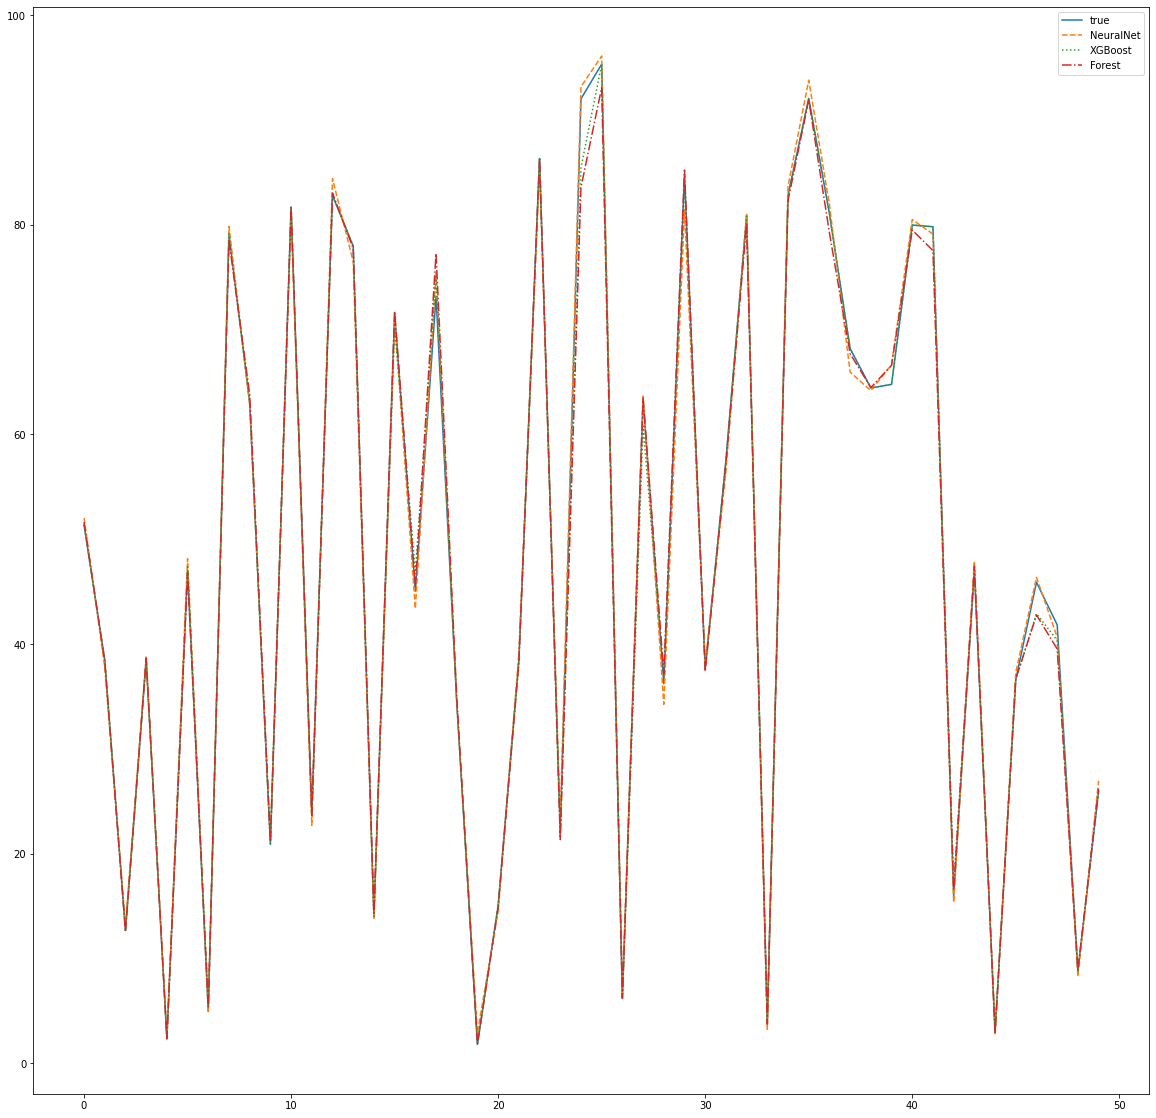

In [70]:
#Построим графики предсказаний моделей против реальных значений
from matplotlib import pyplot as plt
plotmax=50
plt.figure(figsize=(20,20))
plt.plot(range(plotmax),data_for_output["grade"].iloc[:plotmax],label="true")
plt.plot(range(plotmax),data_for_output["NeuralNet"].iloc[:plotmax],label="NeuralNet",linestyle="dashed")
plt.plot(range(plotmax),data_for_output["XGBoost"].iloc[:plotmax],label="XGBoost",linestyle="dotted")
plt.plot(range(plotmax),data_for_output["Forest"].iloc[:plotmax],label="Forest",linestyle="dashdot")
plt.legend()
plt.show()

In [71]:
#Сохраним таблицу в формате .xlsx
data_for_output.to_excel("result.xlsx") 

<h1>Часть 4. Работа с БД</h1>

Задание:
<br>
На основе данных в файле test_result.xlsx, ПМ создает и заполняет записи в таблицах БД SQL-Lite (Рисунок 2) следующим образом:
<br>
•	записи с 180 по 279 записываются сразу после прохождения всего алгоритма работы программы с номерами ID от 1 до 100 (по порядку) и TYME = текущим системным временем,
<br>
•	записи с 370-469 записываются через 1 минуту после прохождения всего алгоритма работы программы с номерами ID от 1 до 100 (по порядку) и TYME = текущим системным временем, 
<br>
•	записи с 1000-1099 записываются через 2 минуты после прохождения всего алгоритма работы программы с номерами ID от 1 до 100 (по порядку) и TYME = текущим системным временем,
<br>
•	записи с 1540-1639 записываются через 3 минуты после прохождения всего алгоритма работы программы с номерами ID от 1 до 100 (по порядку) и TYME = текущим системным временем.


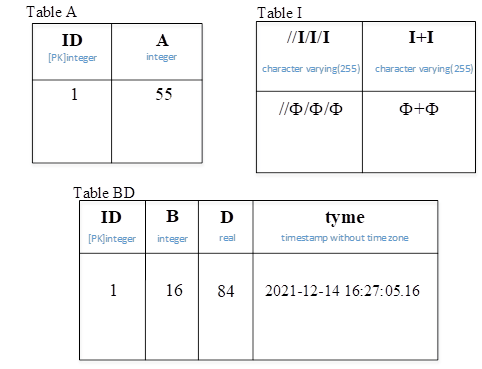

In [102]:
#создадим требуемые таблицы
import sqlite3
try:
    connection = sqlite3.connect('database.db')
    cursor = connection.cursor()
  
    query = '''CREATE TABLE A (
                      id INTEGER,
                      A INTEGER);'''
    cursor.execute(query)
    connection.commit()
    
    query = '''CREATE TABLE I (
                      [//I/I/I] TEXT,
                      [I+I] TEXT);'''
    cursor.execute(query)
    connection.commit()
    
    query = '''CREATE TABLE BD (
                      id INTEGER,
                      B INTEGER,
                      D REAL,
                      TYME TEXT);'''
    cursor.execute(query)
    connection.commit()
    
    cursor.close()

except sqlite3.Error as error:
    print("Connection Error: ", error)
    
finally:
    if (connection):
        connection.close()

In [103]:
#получим текущее значение времени и таймдельта в одну минуту, чтобы прибавлять
from datetime import datetime,timedelta
now = datetime.now()
delta = timedelta(minutes=1)
fmt = "%d/%m/%Y %H:%M:%S"
    
#пишем данные в БД
try:
    connection = sqlite3.connect('database.db')
    cursor = connection.cursor()
    for i,s in enumerate(slices):
        for j,row in enumerate(range(s[0],s[1])):
            query = """INSERT INTO A
                       VALUES ({},'{}');""".format(j,data_for_output["A"].loc[row])
            cursor.execute(query)
                    
            query = """INSERT INTO I
                       VALUES ('{}','{}');""".format(r"//{0}/{0}/{0}".format(data_for_output["I"].loc[row]),
                                                            r"{0}+{0}".format(data_for_output["I"].loc[row]))
            cursor.execute(query)
            
            query = """INSERT INTO BD
                       VALUES ({},{},{},'{}');""".format(j,
                                                         data_for_output["B"].loc[row],
                                                         data_for_output["D"].loc[row],
                                                         (now+delta*i).strftime(fmt)) #Здесь прибавляем нужное кол-во минут
            cursor.execute(query)
            
    connection.commit()
    cursor.close()
except sqlite3.Error as error:
    print("Connection Error: ", error)
    
finally:
    if (connection):
        connection.close()
            

In [104]:
#Проверим, что записалось корректно
try:
    connection = sqlite3.connect('database.db')
    query = "SELECT * FROM I;"
    cursor = connection.cursor()
    cursor.execute(query)
    res = cursor.fetchall()
    cursor.close()
        
except sqlite3.Error as error:
    print("Connection Error: ", error)
    
finally:
    if (connection):
        connection.close()
        
res

[('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 'С+С'),
 ('//С/С/С', 

In [95]:
try:
    connection = sqlite3.connect('database.db')
    query = "SELECT id,BD.B,A.A FROM BD JOIN A ON ;"
    cursor = connection.cursor()
    cursor.execute(query)
    res = cursor.fetchall()
    cursor.close()
        
except sqlite3.Error as error:
    print("Connection Error: ", error)
    
finally:
    if (connection):
        connection.close()
        
res